In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

In [15]:
class model(tf.keras.Model):
    def __init__(self):
        super(model, self).__init__(name="model")
        
        tf.keras.backend.set_floatx('float32')
        
        self.state = tf.keras.layers.InputLayer(input_shape=(4,))
        
        self.hidden1 = tf.keras.layers.Dense(2048, activation='elu', \
                                            kernel_initializer='glorot_uniform')
        
        self.policy = tf.keras.layers.Dense(2, activation='softmax', \
                                            kernel_initializer='he_uniform')
        
        self.value = tf.keras.layers.Dense(1, activation='linear', \
                                            kernel_initializer='he_uniform')
        
        self.optimizer = tf.keras.optimizers.Adam()
        self.huber_loss = tf.keras.losses.Huber(delta=5)
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    
    @tf.function
    def call(self, x):
        x = self.state(x)
        x = self.hidden1(x)
        p = self.policy(x)
        v = self.value(x)
        return p, tf.reshape(v, [-1])
    
    def action(self, state, training=True):
        policy, value = self.call(state)
        policy = policy.numpy()
        # choose action stochastically
        if training:
            return np.array([np.random.choice(len(p), p=p) for p in policy])
        else:
            return np.array([np.argmax(p) for p in policy])
        

    def train_step(self, state, action, reward):
        with tf.GradientTape() as tape:
            policy, value = self.call(state)
            
            # action prob
            indices = tf.range(0, tf.shape(policy)[0]) * tf.shape(policy)[1] + action
            act_prob = tf.gather(tf.reshape(policy, [-1]), indices)
            
            # policy loss
            advantage = reward - value
            policy_loss = -tf.reduce_sum(tf.math.log(act_prob + 1e-10) * advantage)
            
            # value loss
            value_loss = self.huber_loss(value, reward)
            
            # entropy
            entropy = -tf.reduce_sum(act_prob * tf.math.log(act_prob + 1e-10))
            
            #
            loss = policy_loss + 0.5 * value_loss + entropy
            
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.train_loss(loss)
        return self.train_loss.result()

In [16]:
tf.random.set_seed(0)
np.random.seed(0)
agent = model()

In [23]:
env = gym.make("CartPole-v1"); env.seed(0); print('', end='')

In [18]:
%%time
rewards_history, loss_history, episode_count, running_reward = [], [], 0, 0

batch_size = 4
gamma = 0.98

while True:
    S, A, R = [], [], []
    
    for ep in range(batch_size):
        s, a, r = [], [], []

        state = env.reset()
        episode_reward = 0
        for t in range(1, 1000):

            s.append(state)

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action = agent.action(state)[0]
            a.append(action)

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            r.append(reward)

            episode_reward += reward
            if done:
                break
                
        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        rewards_history.append(running_reward)
                
        
        discounted_rewards, discounted_sum = [], 0
        for t in r[::-1]:
            discounted_sum = t + gamma * discounted_sum
            discounted_rewards.insert(0, discounted_sum)
            
        S.extend(s)
        A.extend(a)
        R.extend(discounted_rewards)
        
        #log details
        episode_count += 1
        
    S = tf.convert_to_tensor(S, dtype=np.float32)
    A = tf.convert_to_tensor(A, dtype=np.int32)
    R = tf.convert_to_tensor(R, dtype=np.float32)
    
    loss = agent.train_step(S, A, R).numpy()
    loss_history.append(loss)
    
    if episode_count % 1 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
    
    if running_reward > 475:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 4.18 at episode 4
running reward: 8.93 at episode 8
running reward: 12.17 at episode 12
running reward: 14.73 at episode 16
running reward: 16.44 at episode 20
running reward: 21.06 at episode 24
running reward: 22.92 at episode 28
running reward: 27.42 at episode 32
running reward: 29.97 at episode 36
running reward: 36.98 at episode 40
running reward: 36.47 at episode 44
running reward: 37.97 at episode 48
running reward: 43.07 at episode 52
running reward: 43.48 at episode 56
running reward: 47.02 at episode 60
running reward: 49.82 at episode 64
running reward: 51.33 at episode 68
running reward: 55.30 at episode 72
running reward: 59.35 at episode 76
running reward: 62.63 at episode 80
running reward: 64.47 at episode 84
running reward: 67.49 at episode 88
running reward: 70.64 at episode 92
running reward: 70.19 at episode 96
running reward: 70.40 at episode 100
running reward: 79.64 at episode 104
running reward: 79.43 at episode 108
running reward: 81.19 at epis

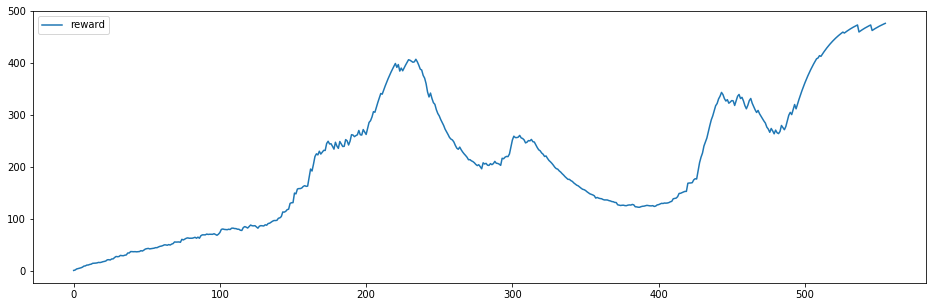

In [19]:
plt.figure(figsize=(16,5))
plt.plot(rewards_history, label="reward")
plt.legend()

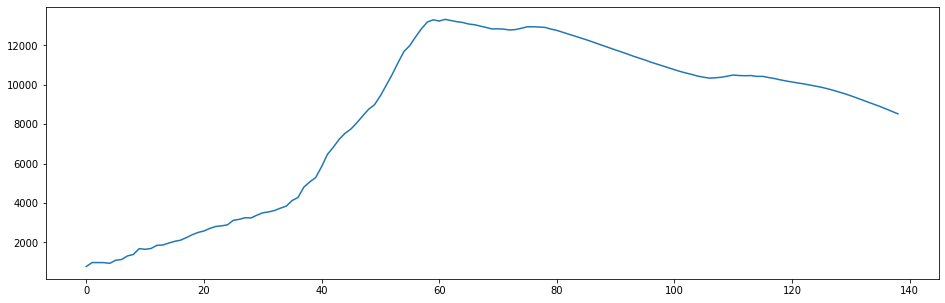

In [20]:
plt.figure(figsize=(16,5))
plt.plot(loss_history)

In [245]:
state = env.reset()
state = tf.convert_to_tensor(state)
state = tf.expand_dims(state, 0)

agent.call(state)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[1.000000e+00, 6.347181e-38, 0.000000e+00, 0.000000e+00]],
       dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-42.354836], dtype=float32)>)

In [206]:
state = env.reset()
for i in range(1000):
    env.render()
    
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action = agent.action(state)[0]
    
    state, reward, done, _ = env.step(action)
    
    if done:
        break
env.close()